In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.inspection import DecisionBoundaryDisplay

import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.ssvep_transformer import Preprocessor, WaveletTransformer, Subsampler

In [2]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    return eeg_data, severity

def build_dataset(directory_list):
    X = []
    y = []
    groups = []
    severities = []
    max_len = 0
    for idx, directory in enumerate(directory_list):
        for file in os.listdir('../data/' + directory):
            file_path = '../data/' + directory + '/' + file
            eeg_data, severity = read_data(file_path)
            X.append(eeg_data)
            y.append(0 if severity == 0 else 1)
            groups.append(idx)
            severities.append(severity)
            max_len = max(max_len, eeg_data.shape[0])
    return X, np.array(y), np.array(groups), np.array(severities), max_len


directory_list = ['2024-01-12', '2024-01-19', '2024-01-22']

X, y, groups, severities, max_len = build_dataset(directory_list)

In [3]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', Preprocessor(max_len=max_len)),
    ('wavelet_transformer', WaveletTransformer()),
    ('subsampler', Subsampler()),
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC(probability=True))
])

grid = {
    'wavelet_transformer__w': [50],
    'subsampler__n_samples': [100],
    'pca__n_components': [4],
    'svm__C': [1],
    'svm__kernel': ['linear', 'rbf', cosine_similarity]
}

grid_search = GridSearchCV(pipeline, grid, cv=LeaveOneGroupOut(), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train, groups=groups_train)
params = grid_search.best_params_
print('Best Params:', params)
print(f'Best Accuracy: {grid_search.best_score_:.2%}')

Best Params: {'pca__n_components': 4, 'subsampler__n_samples': 100, 'svm__C': 1, 'svm__kernel': 'linear', 'wavelet_transformer__w': 50}
Best Accuracy: 88.05%


Accuracy: 89.47%
AUC ROC: 0.96


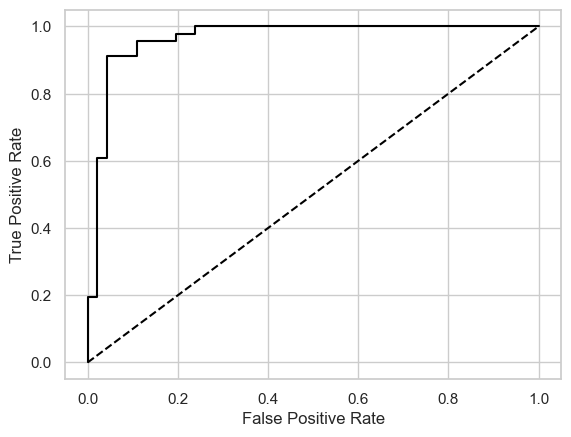

In [4]:
pipeline.set_params(**params)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2%}')

y_pred_proba = pipeline.predict_proba(X)
auc_roc = roc_auc_score(y, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

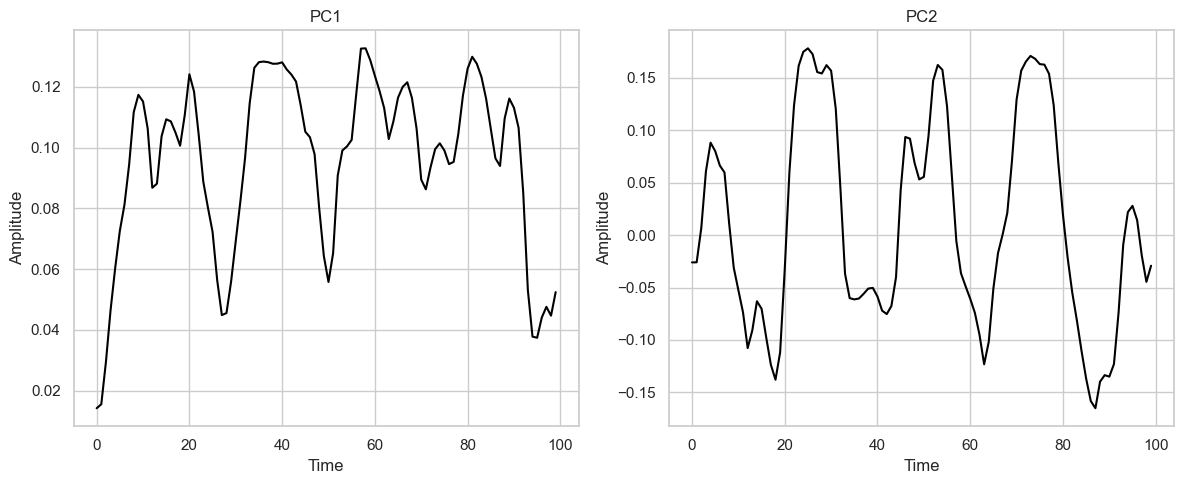

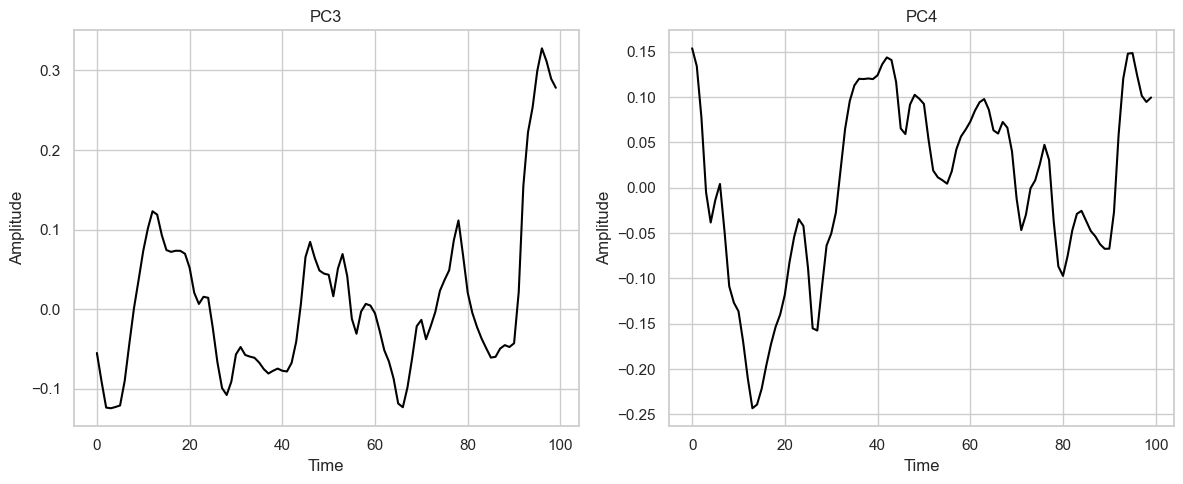

In [5]:
pca = pipeline.named_steps['pca']

num_plots = len(pca.components_)
num_cols = 2
num_rows = (num_plots + 1)//num_cols

for row in range(num_rows):
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(6*num_cols, 5))
    for col in range(num_cols):
        idx = row*num_cols + col
        if idx >= num_plots:
            break
        pc = pca.components_[idx]
        axes[col].plot(pc, color='black')
        axes[col].set_xlabel('Time')
        axes[col].set_ylabel('Amplitude')
        axes[col].set_title('PC' + str(idx + 1))
        fig.tight_layout()
    plt.show()

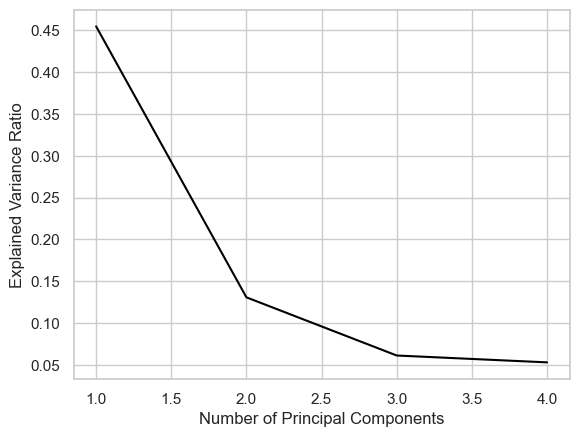

In [6]:
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.plot(range(1, num_components + 1), explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

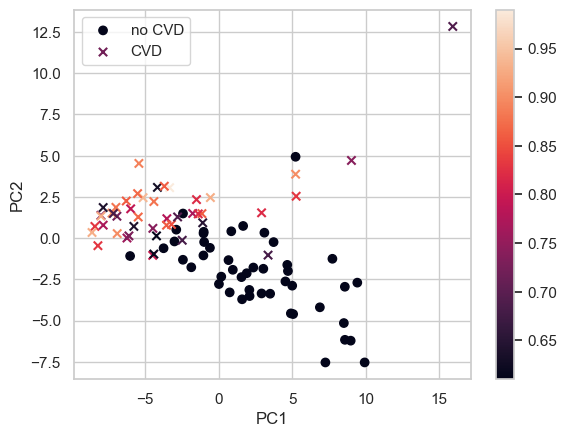

In [7]:
X_pca = pipeline.named_steps['preprocessor'].transform(X)
X_pca = pipeline.named_steps['wavelet_transformer'].transform(X_pca)
X_pca = pipeline.named_steps['subsampler'].transform(X_pca)
X_pca = pipeline.named_steps['scaler'].transform(X_pca)
X_pca = pipeline.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities)[y == i])

plt.legend()
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

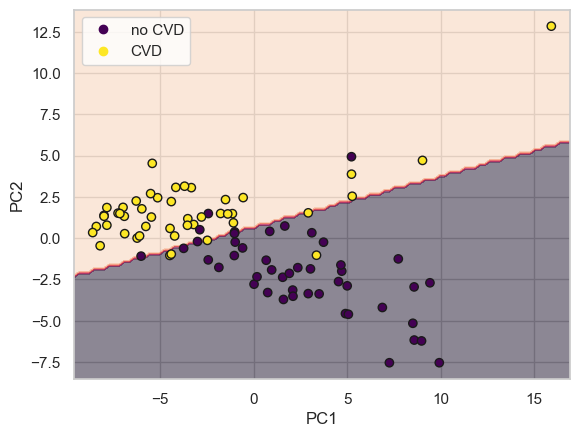

In [8]:
X_reduced = X_pca[:,:2]

model = pipeline.named_steps['svm']
model.kernel = 'linear'
model.fit(X_reduced, y)

disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()

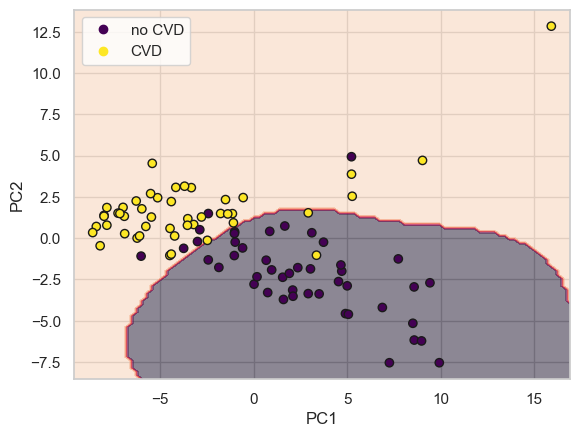

In [9]:
model.kernel = 'rbf'
model.fit(X_reduced, y)

disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()

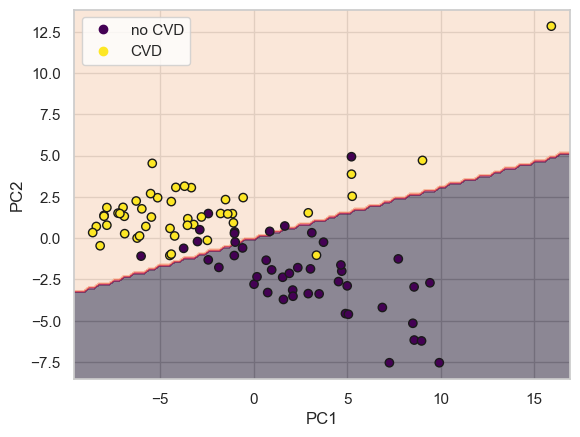

In [10]:
model.kernel = cosine_similarity
model.fit(X_reduced, y)

disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()